# Use Case: Using land cover product to quantify urbanization trends.

## Assessment of trends in urbanization

### About
In this Use Case we will access the ***Land cover classification gridded maps from 1992 to present derived from satellite observations*** (henceforth, LC) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse the spatial patterns of the LC reliability over a given Area of Interest (AoI).

**This Use Case aims to address the following User Question:**

1. Can we measure urbanization trends in the Iberian Peninsula? Are we able to disclose significant regional contrasts?


**This Use Case comprises the following steps:**

1. Define the AoI, search and download LC data.
2. Inspect and view data for the defined AoI (Iberian Peninsula).
3. Analyzing Temporal Trends of Urbanization
4. Map Urbanization trends by NUTS regions in the AoI.
5. Main Takeaways.

**The main takeaways of this Use Case are:**

* Cataluña, Comunitat Valenciana, and Andalucía lead in terms of urban growth rates with respective values of 31.275 km²/year, 29.499 km²/year, and 29.224 km²/year.

* Between 1992 and 2020, the urban area of Algarve and Alentejo grew around 4 times but because the innitial area occupied by urban fabric was small in both regions the slope graphs did not portrait the growth, justifying the importance of different methods to explore the data.

* By 2022, the regions where urban areas constitute the most substantial portion are Andalucía, Cataluña, and Northern Portugal.

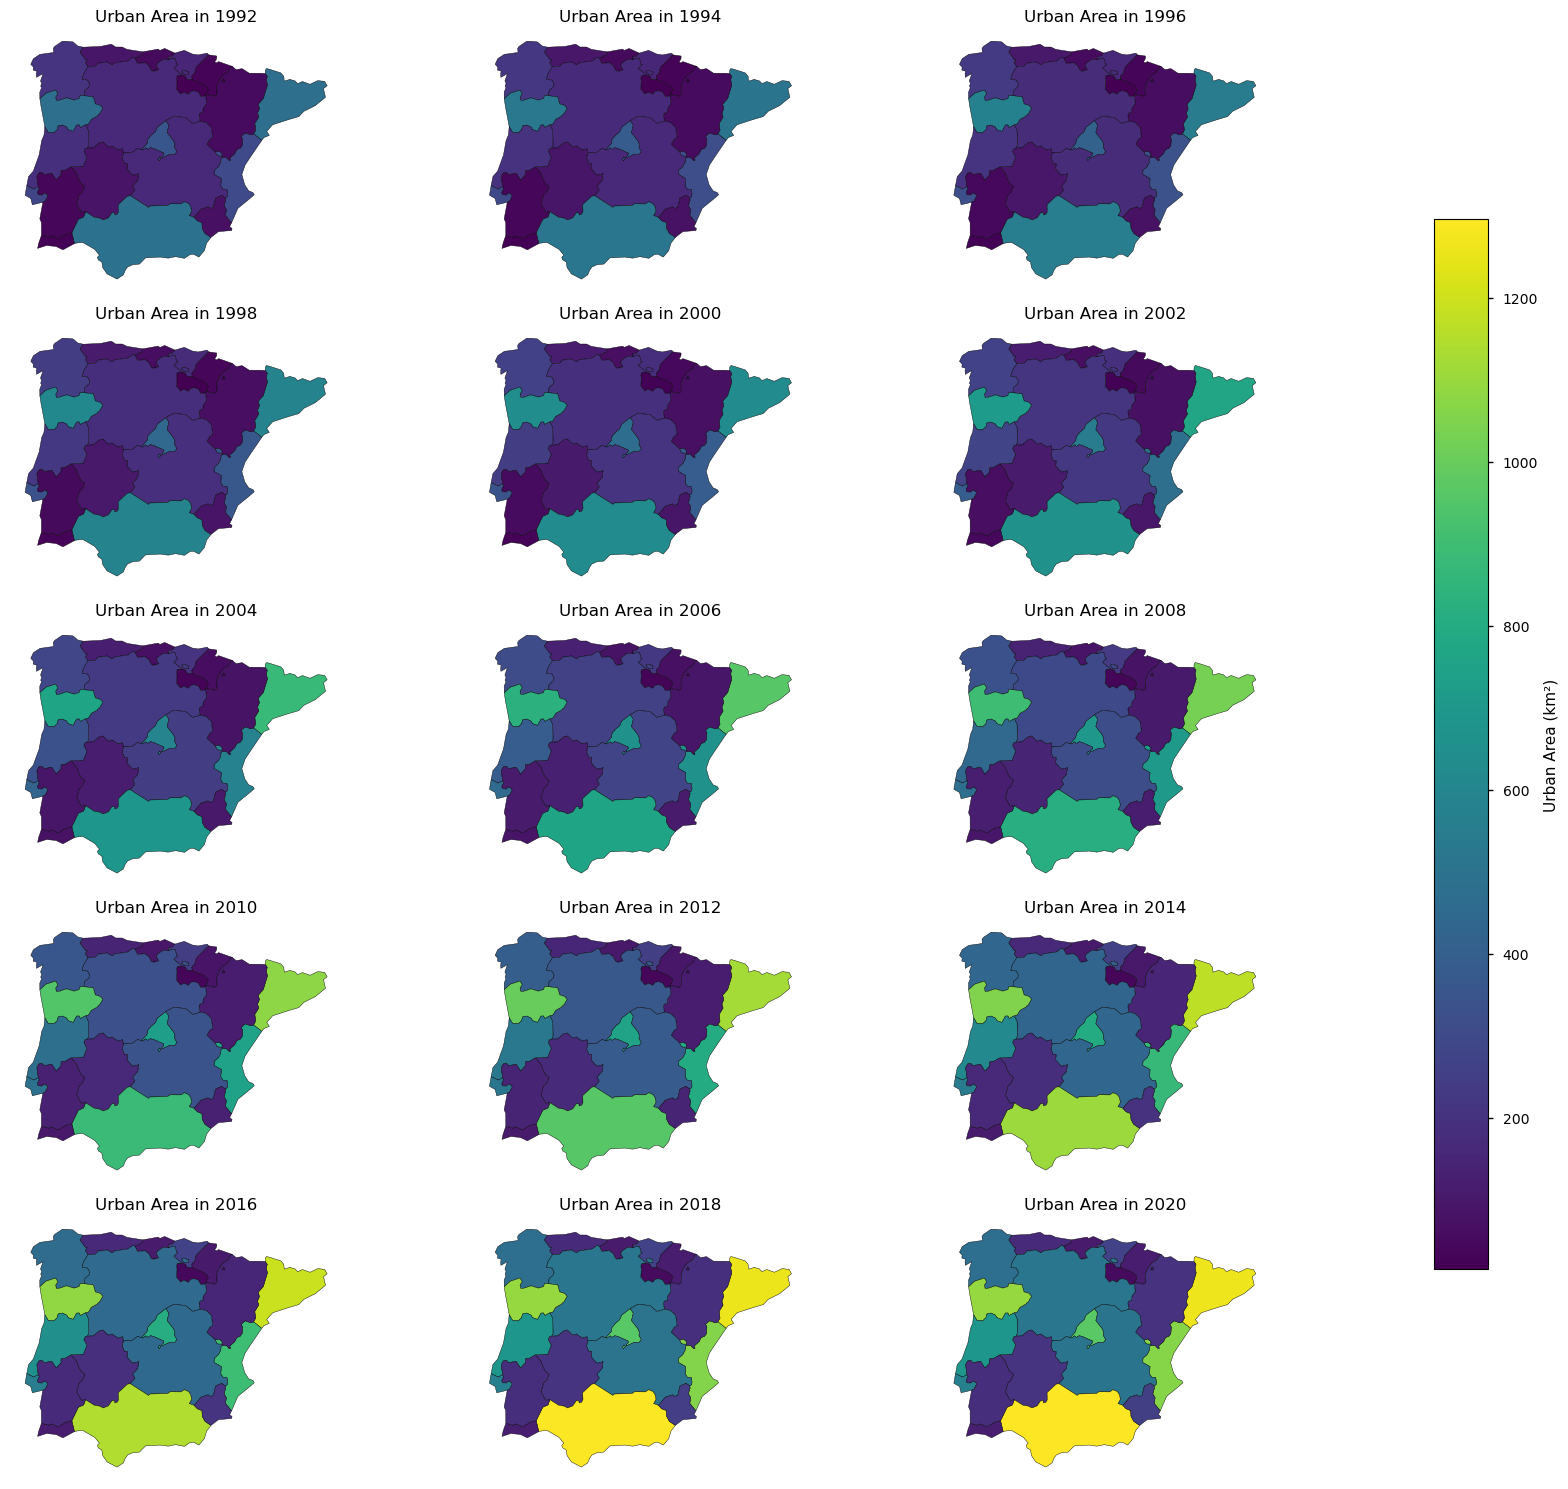

## 1. Define the AoI, search and download LC data.
Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### Install CDS API
To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).
If you already have the CDS API installed, you can skip or comment this step.

In [1]:
!pip install cdsapi

### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this type of data we will use libraries for working with multidimensional arrays, in particular Xarray. 
We will also need libraries for plotting and viewing data.

In [40]:
import pandas as pd
import geopandas as gpd # import vector geospatial data
import matplotlib.pyplot as plt # plot graphs
import numpy as np # perform trigonometric calculations
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import shapely.geometry # work with geometric shapes
from shapely.geometry import Polygon


import regionmask # transform attributes and geometries into specific regions
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils 

plt.style.use("seaborn-v0_8-notebook") # predifined style of all graphical outputs

### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu. Here you can search for 'Satellite observations' using the search bar. The data we need for this tutorial is the ***Land cover classification gridded maps from 1992 to present derived from satellite observations***. This catalogue entry provides global Land Cover Classification (LCC) maps with a very high spatial resolution, with a L4 processing level, on an annual basis with a one-year delay, following the Global Climate Observing System (GCOS) convention. LULC maps correspond to a global classification scheme, encompassing 22 classes. For intercomparison consistency, <ins>LC classes are grouped into the six IPCC land categories:</ins> **cropland, forest, grassland, wetland, settlement, and other land (shrubland, sparse vegetation, bare area and water)**, as gathered from several international sources.

The dataset consists of 2 versions (v2.0.7 produced by the European Space Agency (ESA) Climate Change Initiative (CCI) and v2.1.1 produced by Copernicus Climate Change Service (C3S)).

Data specifications for this use case:
* **Year:** 1992 and 2020
* **Version:** v2.0.7 for 1992 and v2.1.1 for 2020
* **Format:** Zip files

At the end of the download form, select “**Show API request**”. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook …

Download data
… having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the **terms and conditions** of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the “**Show API request**” option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [41]:
#Years to download
years = [1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018,2020]


# Region of interest (Iberian Peninsula)
lon_slice = slice(-10, 4)
lat_slice = slice(45, 35)

# Shapefile with regions (NUTS2)
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip" #NUTS2 download path

In [42]:
# List of requests to retrieve data
collection_id = "satellite-land-cover"
requests = [
    {
        "variable": "all",
        "format": "zip",
        "version": "v2.0.7cds" if year < 2016 else "v2.1.1",
        "year": year,
    }
    for year in years
]

In [43]:
# Download and regionalize by AoI
ds = download.download_and_transform(
    collection_id,
    requests,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
)
ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")

100%|██████████| 15/15 [00:01<00:00, 14.91it/s]


In [44]:
#Inspect the database
ds

<xarray.Dataset>
Dimensions:              (year: 15, latitude: 3600, longitude: 5040, bounds: 2)
Coordinates:
  * latitude             (latitude) float64 45.0 45.0 44.99 ... 35.01 35.0 35.0
  * longitude            (longitude) float64 -9.999 -9.996 ... 3.996 3.999
    lat_bounds           (latitude, bounds) float64 dask.array<chunksize=(3600, 2), meta=np.ndarray>
    lon_bounds           (longitude, bounds) float64 dask.array<chunksize=(5040, 2), meta=np.ndarray>
    time_bounds          (year, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
  * year                 (year) int64 1992 1994 1996 1998 ... 2016 2018 2020
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (year, latitude, longitude) uint8 dask.array<chunksize=(1, 3600, 5040), meta=np.ndarray>
    processed_flag       (year, latitude, longitude) float32 dask.array<chunksize=(1, 3600, 5040), meta=np.ndarray>
    current_pixel_state  (year, latitude, longitude) float32 dask.array<chunksize=(1, 3600, 5040), meta=np.ndarray>
    observation_count    (year, latitude, longitude) uint16 dask.array<chunksize=(1, 3600, 5040), meta=np.ndarray>
    change_count         (year, latitude, longitude) uint8 dask.array<chunksize=(1, 3600, 5040), meta=np.ndarray>
    crs                  (year) int32 -2147483647 -2147483647 ... -2147483647
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

## 2. Inspect and view data for the defined AoI (Iberian Peninsula)
### Compute areas by regions

To further identify changes in LC patterns, in this user question, NUTS 2 will be used, providing the information reggarding the main regions/parcels of the Iberian Peninsula.

The NUTS are a hierarchical system divided into 3 levels (https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts). NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correpsond to small regions for specific diagnoses. Additionally a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 


The step below masks the Land Cover data according to the NUTS 2 boundaries and calculate the area of each pixel (weighted by Latitude). For each NUTS 2, we proceed with the analysis and visual inspection of Land Cover areas per class and corresponding percentages during the elected period.

### Mask regions

First, we need to establish the geometry of the NUTS region (level 2) in order to make the corresponding statistics.

In [45]:
# Define longitude and latitude bounds for the region of interest
lon_bounds = [-10.18, 1]
lat_bounds = [36.5, 43]
crs = "epsg:4326" #coordinate system

lon_bounds += sorted(lon_bounds, reverse=True)
lat_bounds = [lat for lat in lat_bounds for _ in range(2)]

bbox = shapely.Polygon(zip(lon_bounds, lat_bounds)) # create a bounding box polygon using Shapely

# Data filter
gdf = gpd.read_file(shapefile_url) # read the shapefile NUTS2
gdf = gdf[gdf["LEVL_CODE"] == 2] # keep only features at the second administrative level (LEVL_CODE == 2)
gdf = gdf[gdf.intersects(bbox)] # keep only features that intersect with the defined bounding box
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))] # keep only features with NUTS_ID starting with "ES" or "PT"
gdf = gdf.to_crs(crs)

ds.rio.write_crs(crs, inplace=True)

regions = regionmask.from_geopandas(gdf, names="NUTS_NAME") # create regions based on the filtered GeoPandas DataFrame
mask = regions.mask(ds["longitude"], ds["latitude"]) # create a mask based on the regions and the xarray dataset's coordinates

### Compute cell area

Then, we can calculate the area of each pixel taking into consideration the curvature of the earth (i.e., weighted by Latitude).

In [46]:
# Calculate Pixel Area
scaling_factor = 0.002778 # define a scaling factor for conversion
resolution_km = scaling_factor * 111.195 # calculate the grid cell resolution in kilometers
indexes = xr.DataArray(range(ds.sizes["latitude"]), dims="latitude") # create an array of indexes representing latitude positions
lats = ds["latitude"].max() - indexes * scaling_factor
grid_cell_area = resolution_km**2 * np.cos(np.radians(lats))
grid_cell_area.attrs = {
    "standard_name": "cell_area",
    "long_name": "Area",
    "units": "km2",
}
ds = ds.assign_coords(cell_area=grid_cell_area)

# 3. Analyzing Temporal Trends of Urbanization
### Evaluating the direction and magnitude of changes over time

We employ the Mann-Kendall trend test to identify potential trends within time-series data, focusing on examining whether there exists a statistically significant increase or decrease in urban areas over the years.

Complementing the Mann-Kendall test, the Theil-Sen estimator provides a method to estimate the gradient of a trend line in the time-series data. It determines the slope of the line that most accurately represents the changes in urban areas across the years.

The combination of both tests allows for a comprehensive understanding of the trend's direction and its rate of change.

### Plot trends by region

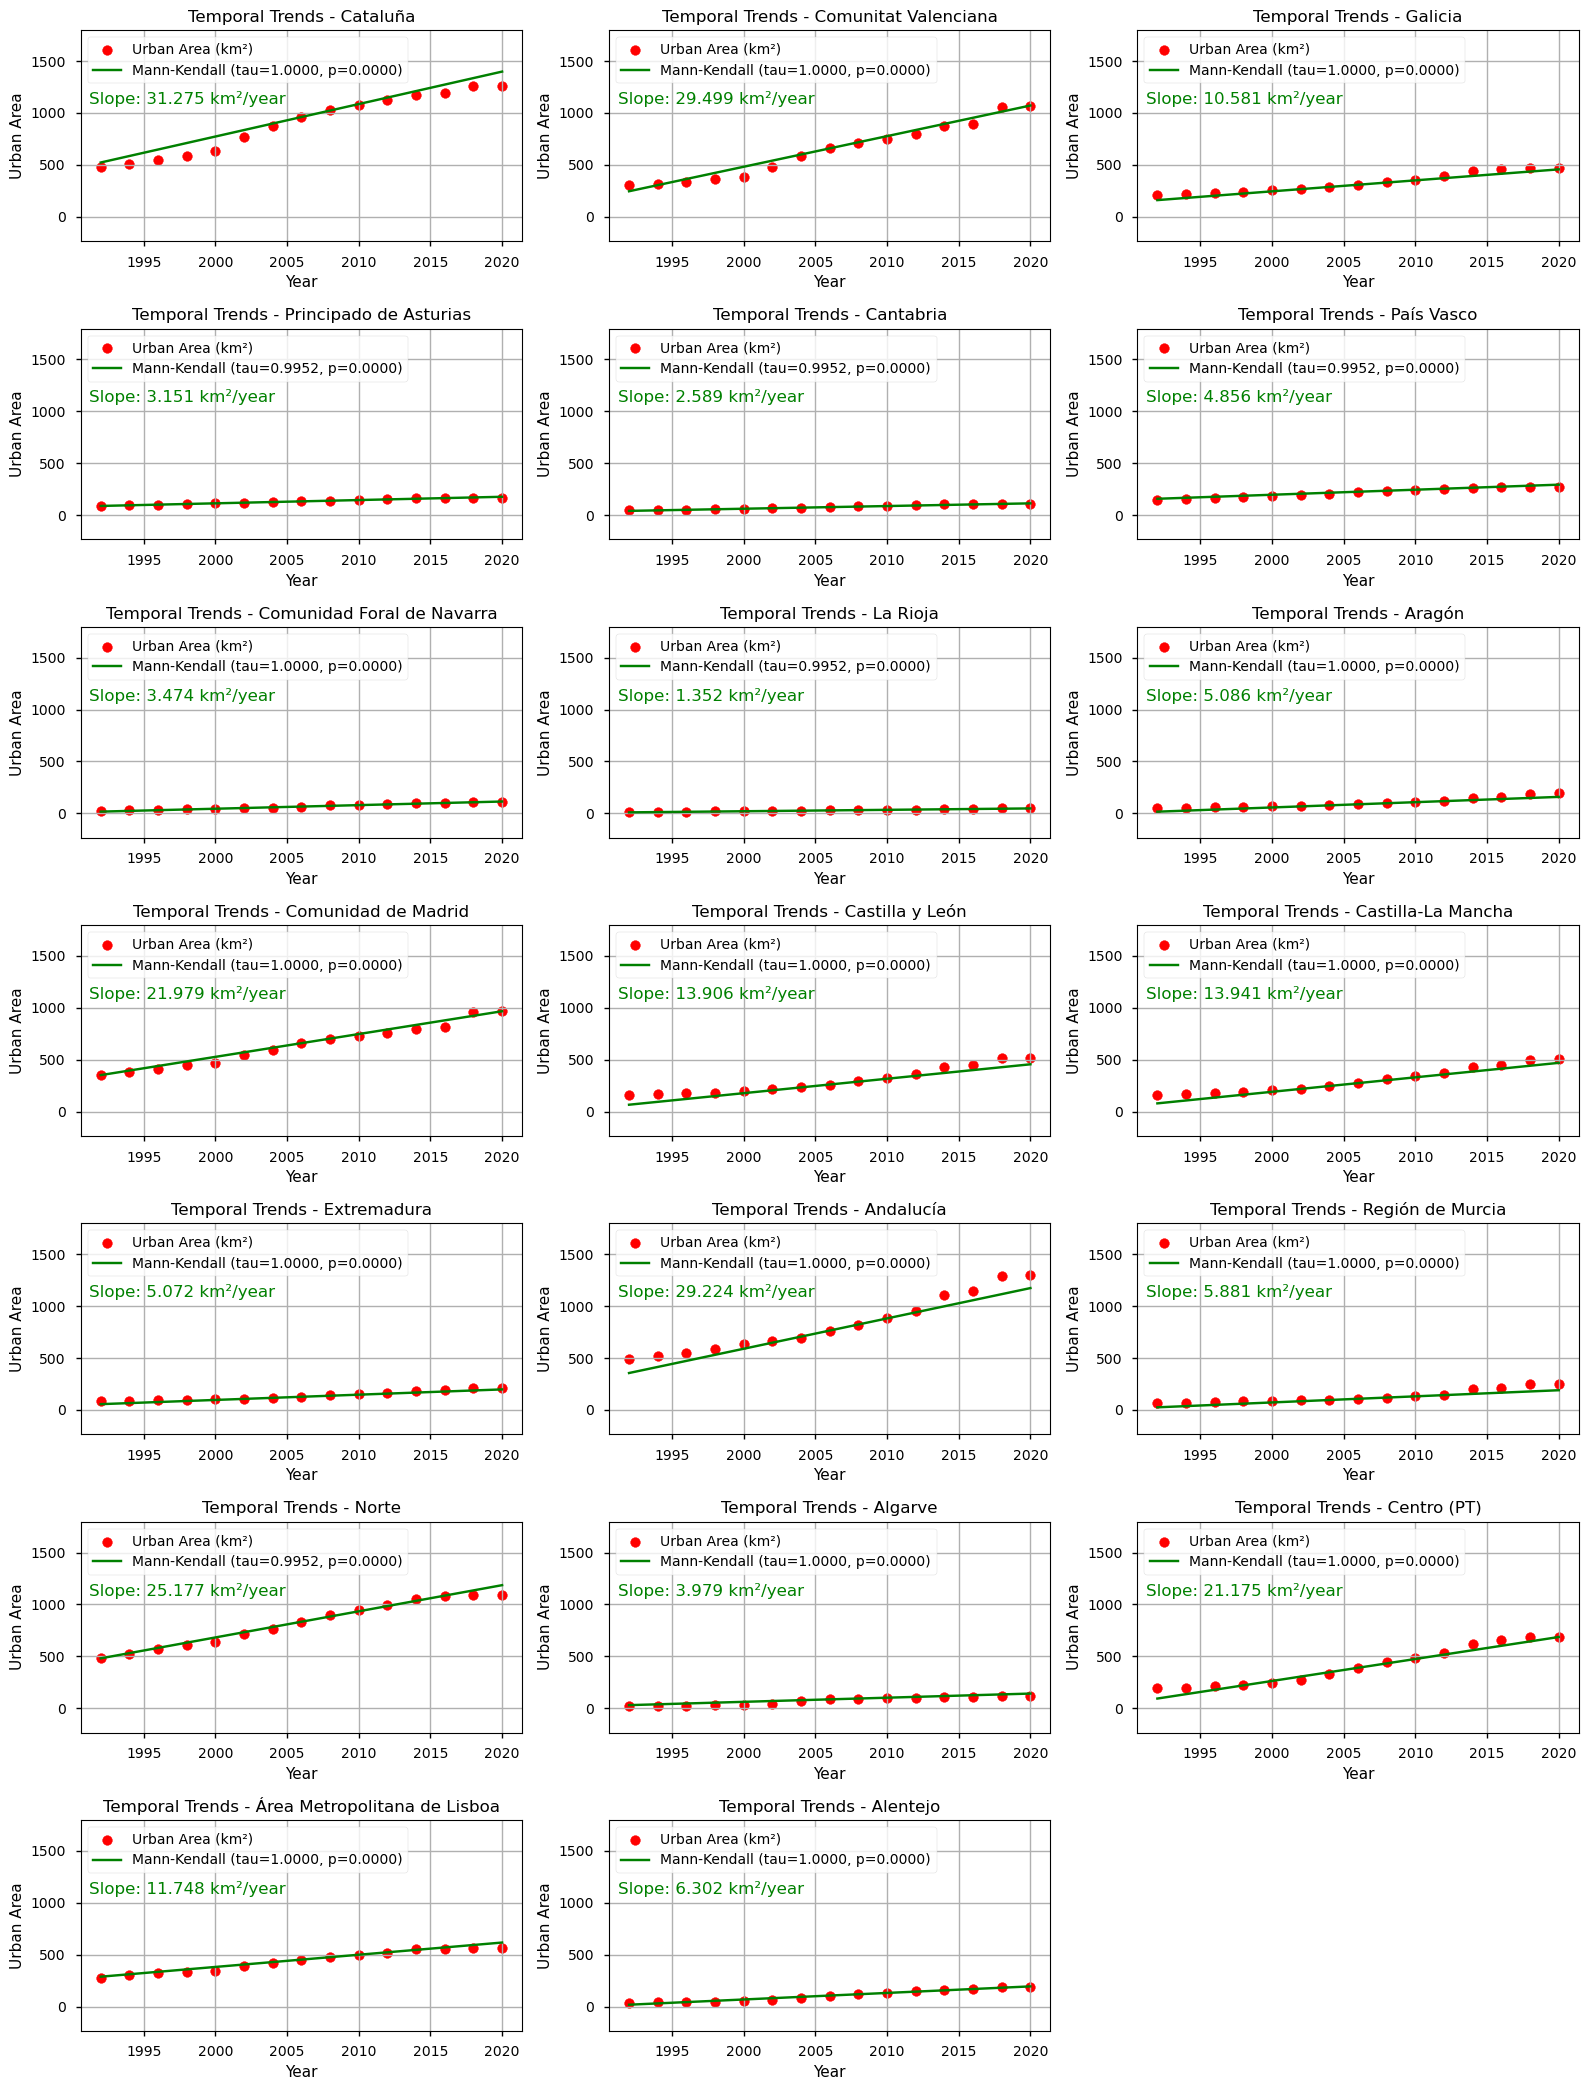

In [47]:
import numpy as np
from scipy.stats import kendalltau
from scipy.stats import theilslopes

slope = {}  # dictionary with the slope for every NUTS region
growth = {}  # dictionary with a dictionary of the urban area of every year, for every NUTS region
urban_area_values = []  # To collect all urban area values across regions

for index, ds_region in ds.groupby(mask):  # for each NUTS region
    urban_area = {}  # create a dictionary with keys = years and values = urban area in those regions
    region = regions[int(index)].name

    for j in range(len(ds_region['year'].values)):  # for each year of our dataset
        # calculate the urban area for each year
        year = ds_region['year'].values[j]
        lccs_class = ds_region['lccs_class'][j].values
        area = ds_region["cell_area"].values
        total_area = 0
        for i in range(len(lccs_class)):
            if lccs_class[i] == 190:
                total_area += area[i]
        urban_area[year] = total_area

    growth[region] = urban_area
    urban_area_values.extend(urban_area.values())  # Collect urban area values

    years = list(urban_area.keys())
    values = list(urban_area.values())
    
# Number of regions
num_regions = len(growth)
cols = 3  # For example, you can have 3 plots in a row.
rows = int(np.ceil(num_regions / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))  # Adjust the figsize for better visualization.

# Flatten the axes for easier iteration
axes = axes.ravel()

# Calculate the common y-axis limits
y_min = min(urban_area_values) - 250
y_max = max(urban_area_values) + 500

# Iterate through the regions and create plots on the same image
for idx, region in enumerate(growth):
    years = list(growth[region].keys())
    values = list(growth[region].values())
    
    tau, p_value = kendalltau(years, values)
    slope, intercept, _, _ = theilslopes(values, years)

    # Plot the data points
    axes[idx].scatter(years, values, label='Urban Area', color='r')

    # Plot Mann-Kendall trend line
    axes[idx].plot(years, [slope * year + intercept for year in years], color='g')

    # Add labels and legend
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Urban Area')
    axes[idx].set_title(f'Temporal Trends - {region}')
    axes[idx].grid(True)
    axes[idx].set_ylim(y_min, y_max)

    # Add the legend with slope information
    axes[idx].legend([f'Urban Area (km²)', f'Mann-Kendall (tau={tau:.4f}, p={p_value:.4f})'], loc='upper left')

    # Add the slope information as text just below the legend
    axes[idx].text(0.02, 0.65, f'Slope: {slope:.3f} km²/year', fontsize=12, color='g', transform=axes[idx].transAxes)

# Remove any unused subplots
for idx in range(num_regions, rows*cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


### Plot the regions with the highest slope

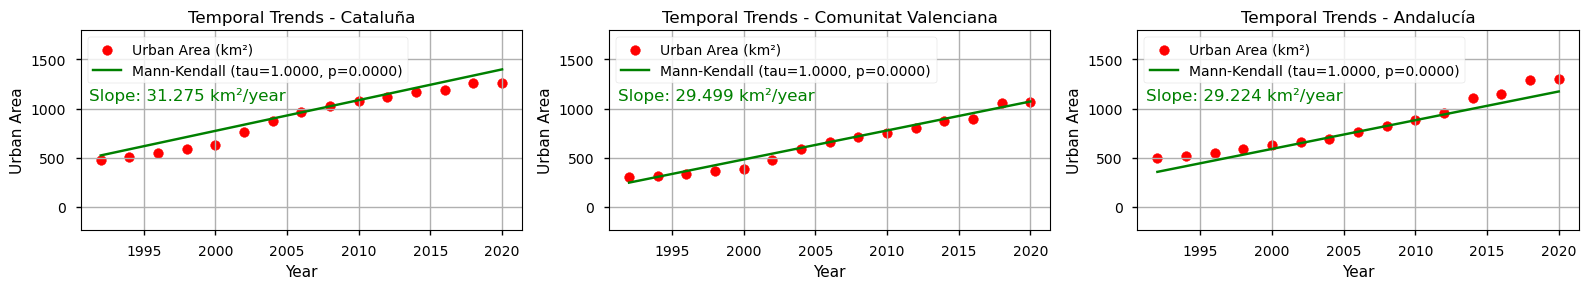

In [48]:
import numpy as np
from scipy.stats import kendalltau
from scipy.stats import theilslopes
import matplotlib.pyplot as plt

slope_dict = {}  # dictionary with the slope for every NUTS region
intercepts_dict = {}  # dictionary with the intercept for every NUTS region
growth = {}  # dictionary with a dictionary of the urban area of every year, for every NUTS region
urban_area_values = []  # To collect all urban area values across regions

for index, ds_region in ds.groupby(mask):  # for each NUTS region
    urban_area = {}  # create a dictionary with keys = years and values = urban area in those regions
    region = regions[int(index)].name

    for j in range(len(ds_region['year'].values)):  # for each year of our dataset
        year = ds_region['year'].values[j]
        lccs_class = ds_region['lccs_class'][j].values
        area = ds_region["cell_area"].values
        total_area = 0
        for i in range(len(lccs_class)):
            if lccs_class[i] == 190:
                total_area += area[i]
        urban_area[year] = total_area

    growth[region] = urban_area
    urban_area_values.extend(urban_area.values())  # Collect urban area values

    years = list(urban_area.keys())
    values = list(urban_area.values())
    
    slope_value, intercept, _, _ = theilslopes(values, years)
    slope_dict[region] = slope_value
    intercepts_dict[region] = intercept

# Sort regions by slope values in descending order and take the top three
top_regions = sorted(slope_dict, key=slope_dict.get, reverse=True)[:3]

# Number of regions
num_regions = len(top_regions)
cols = 3
rows = int(np.ceil(num_regions / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))

# Flatten the axes for easier iteration
axes = axes.ravel()

# Calculate the common y-axis limits
y_min = min(urban_area_values) - 250
y_max = max(urban_area_values) + 500

# Iterate through the top regions and create plots on the same image
for idx, region in enumerate(top_regions):
    years = list(growth[region].keys())
    values = list(growth[region].values())
    
    tau, p_value = kendalltau(years, values)
    slope_for_region = slope_dict[region]
    intercept_for_region = intercepts_dict[region]

    axes[idx].scatter(years, values, label='Urban Area', color='r')
    axes[idx].plot(years, [slope_for_region * year + intercept_for_region for year in years], color='g')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Urban Area')
    axes[idx].set_title(f'Temporal Trends - {region}')
    axes[idx].grid(True)
    axes[idx].set_ylim(y_min, y_max)
    axes[idx].legend([f'Urban Area (km²)', f'Mann-Kendall (tau={tau:.4f}, p={p_value:.4f})'], loc='upper left')
    axes[idx].text(0.02, 0.65, f'Slope: {slope_for_region:.3f} km²/year', fontsize=12, color='g', transform=axes[idx].transAxes)

plt.tight_layout()
plt.show()


### Results analysis
Across all regions, there's a consistent trend of urban area growth over the years. The growth is represented by the upward slope of the green lines.

Mann-Kendall tau: For most regions, the Mann-Kendall tau value is close to 1 (either 1.0000 or 0.9952), indicating a strong positive trend. The associated p values are all 0.0000, suggesting that the trend is statistically significant.

Slope: The slope provides the rate of urban area growth per year in km²/year. The values differ across regions, indicating variable growth rates. For instance: "Comunitat Valenciana" has one of the highest growth rates at 29.499 km²/year. "Cantabria" has one of the lowest at 2.589 km²/year.

Consistency: Almost all regions show a very consistent growth in urban area, with only minor fluctuations over the 25-year period.

# 5. Map Urbanization trends by NUTS regions in the AoI

### Load and organize the necessary data

In [49]:
# Load the NUTS shapefile for 2021
nuts = gpd.read_file('./NUTS_RG_20M_2021_4326.shp')

# Subset the NUTS shapefile to the level you want to analyze
nuts_level_2 = nuts[nuts['LEVL_CODE'] == 2]

# Define the bounding box for the Continental part of the Iberian Peninsula
xmin, ymin, xmax, ymax = -10.18, 36.5, 1, 43
bbox = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])

# Select only those NUTS polygons that intersect with the bounding box of the Iberian Peninsula
iberian_nuts = nuts_level_2[nuts_level_2.intersects(bbox)]

# Filter the rows based on nuts_id column
cont_iberian_nuts = iberian_nuts[iberian_nuts['NUTS_ID'].str.startswith(('ES', 'PT'))]

#Assign a common Coordinate Reference System (CRF) to the NUTS gdf and the xarray
cont_iberian_nuts = cont_iberian_nuts.to_crs('epsg:4326')

In [50]:
# Create dataset with the bounds to determine the slice values (regions)
pt_aoi = cont_iberian_nuts

# Merge the GeoDataFrame with the slope DataFrame based on "NUTS_NAME"
slope_df = pd.DataFrame(list(slope_dict.items()), columns=["NUTS_NAME", "Slope"])
merged_df = pt_aoi.merge(slope_df, on="NUTS_NAME")

#merged_df

### Plot the urban area per year in the AoI regions

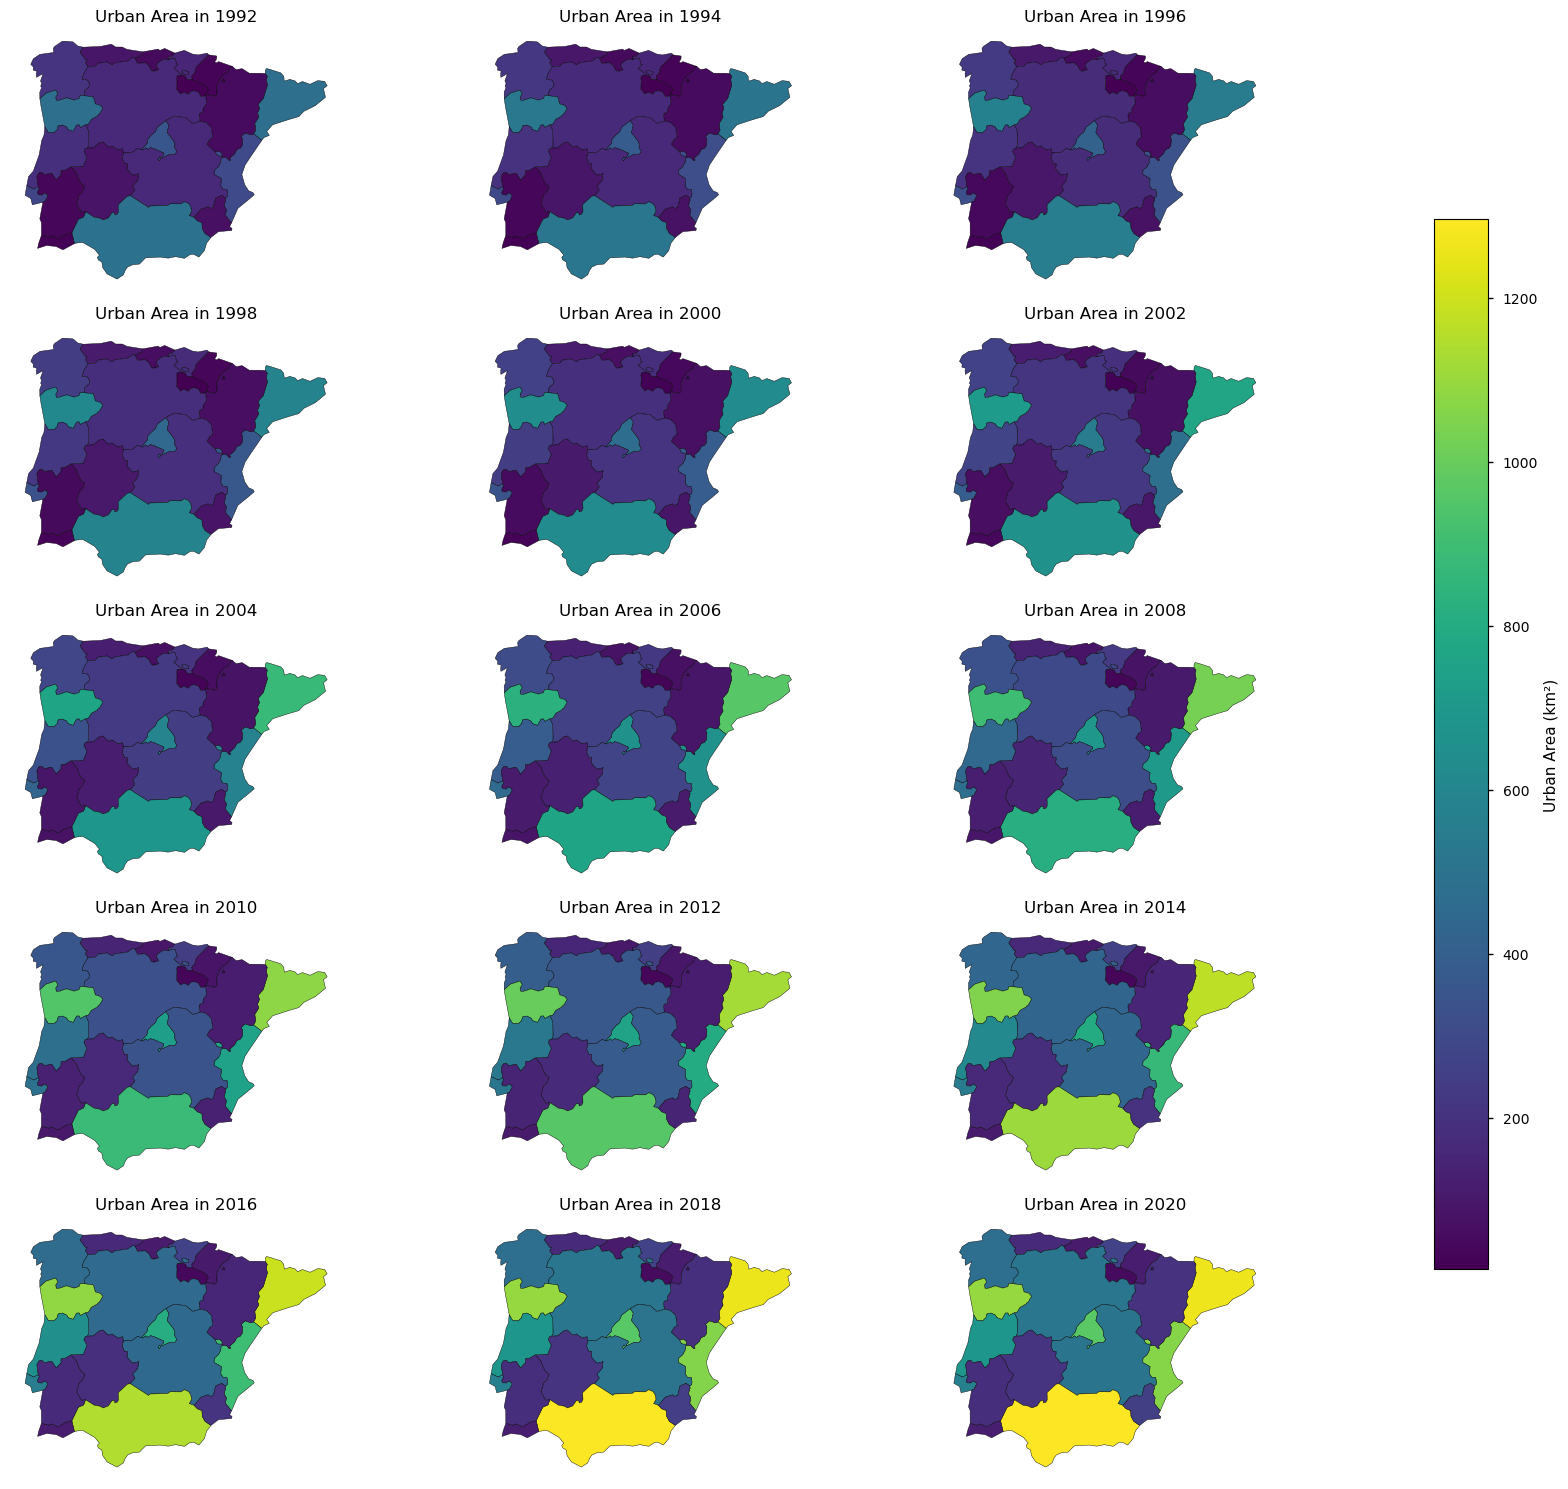

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert the "growth" dictionary into a DataFrame suitable for plotting
growth_df = pd.DataFrame([(region, year, value) for region, years in growth.items() for year, value in years.items()],
                         columns=["NUTS_NAME", "Year", "Urban_Area"])

# Pivot the DataFrame to have years as columns
growth_pivot = growth_df.pivot(index="NUTS_NAME", columns="Year", values="Urban_Area").reset_index()

# Merge the pivoted DataFrame with "pt_aoi" based on "NUTS_NAME"
pt_aoi_growth = pt_aoi.merge(growth_pivot, on="NUTS_NAME")

#Extract years from the DataFrame, assuming they start from the second column
years = growth_pivot.columns[1:]

# Calculate the number of rows and columns for the subplots
n_cols = 3
n_rows = int(np.ceil(len(years) / n_cols))

# Create a figure with multiple axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3), squeeze=False)

# Normalize color scale across all maps
norm = plt.Normalize(vmin=pt_aoi_growth[years.min()].min(), vmax=pt_aoi_growth[years.max()].max())

# Plot each year in a separate subplot
for idx, year in enumerate(years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    pt_aoi_growth.plot(column=year, cmap="viridis", ax=ax, norm=norm, edgecolor='k')
    ax.set_title(f"Urban Area in {year}")
    ax.axis('off')  # Turn off the axis

# Hide any unused subplots
for idx in range(len(years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Adjust the layout to prevent the subplots from overlapping
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Urban Area (km²)")

plt.show()



### Map the change in Urban Area per year

Minimum difference: 0.0
Maximum difference: 166.19160641274755


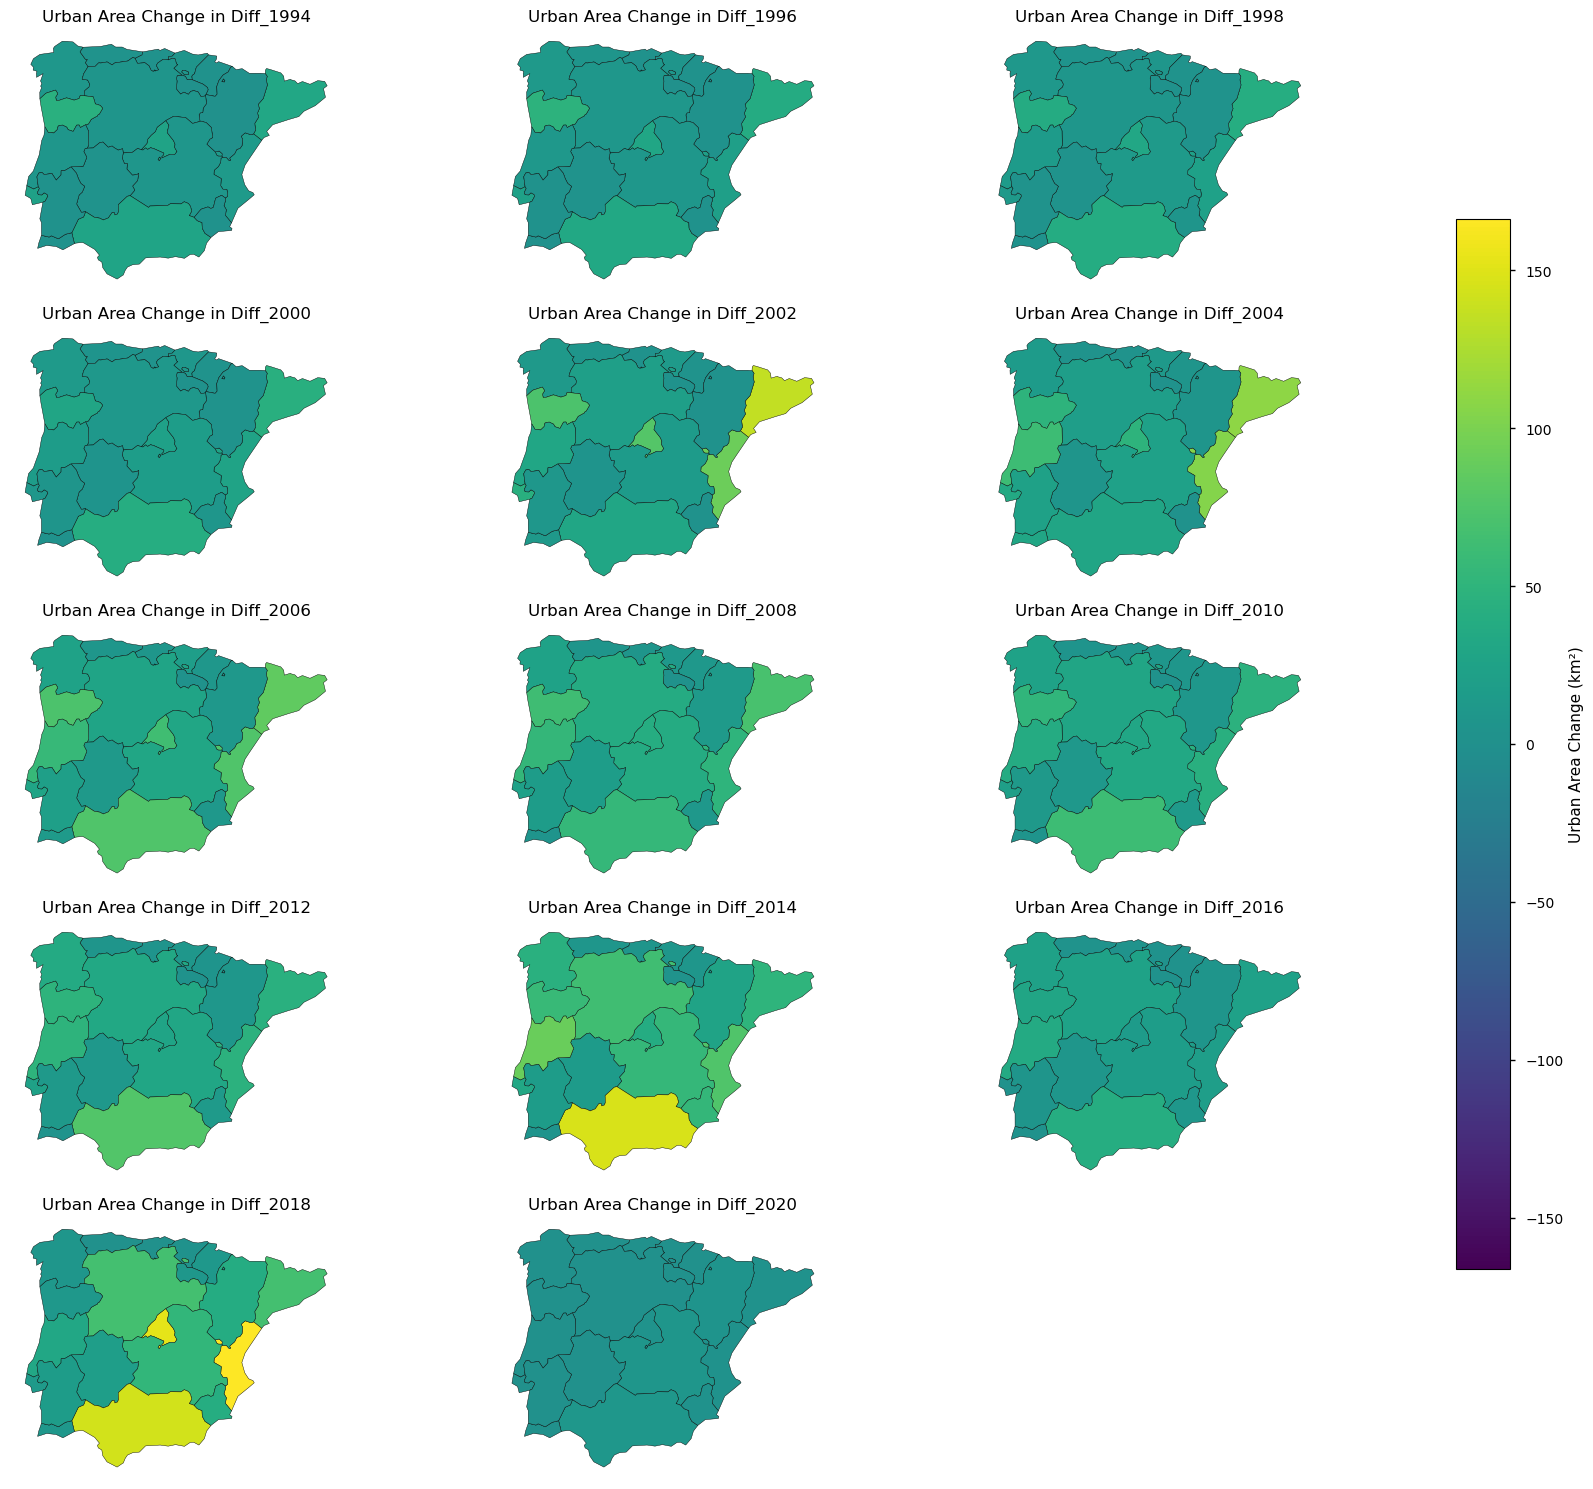

In [55]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Your existing code for creating 'pt_aoi_growth'...
# ...

# Calculate year-to-year differences, assuming the 'years' list is sorted
for i in range(1, len(years)):
    pt_aoi_growth[f'Diff_{years[i]}'] = pt_aoi_growth[years[i]] - pt_aoi_growth[years[i-1]]

# Update 'years' to only include the difference columns
diff_years = [f'Diff_{year}' for year in years[1:]]

# Check the actual min and max differences to ensure there is variation
actual_min_diff = pt_aoi_growth[diff_years].min().min()
actual_max_diff = pt_aoi_growth[diff_years].max().max()

print("Minimum difference:", actual_min_diff)
print("Maximum difference:", actual_max_diff)

# Normalize color scale across all difference maps, symmetrically around zero
min_diff = min(actual_min_diff, -actual_max_diff)
max_diff = max(-actual_min_diff, actual_max_diff)

norm = plt.Normalize(vmin=min_diff, vmax=max_diff)

# Calculate the number of rows and columns for the subplots
n_cols = 3
n_rows = int(np.ceil(len(diff_years) / n_cols))

# Create a figure with multiple axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3), squeeze=False)

# Plot each year's difference in a separate subplot using a diverging colormap
for idx, diff_year in enumerate(diff_years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    pt_aoi_growth.plot(column=diff_year, cmap="viridis", ax=ax, norm=norm, edgecolor='k')
    ax.set_title(f"Urban Area Change in {diff_year}")
    ax.axis('off')  # Turn off the axis

# Hide any unused subplots
for idx in range(len(diff_years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Adjust the layout to prevent the subplots from overlapping
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Urban Area Change (km²)")

plt.show()


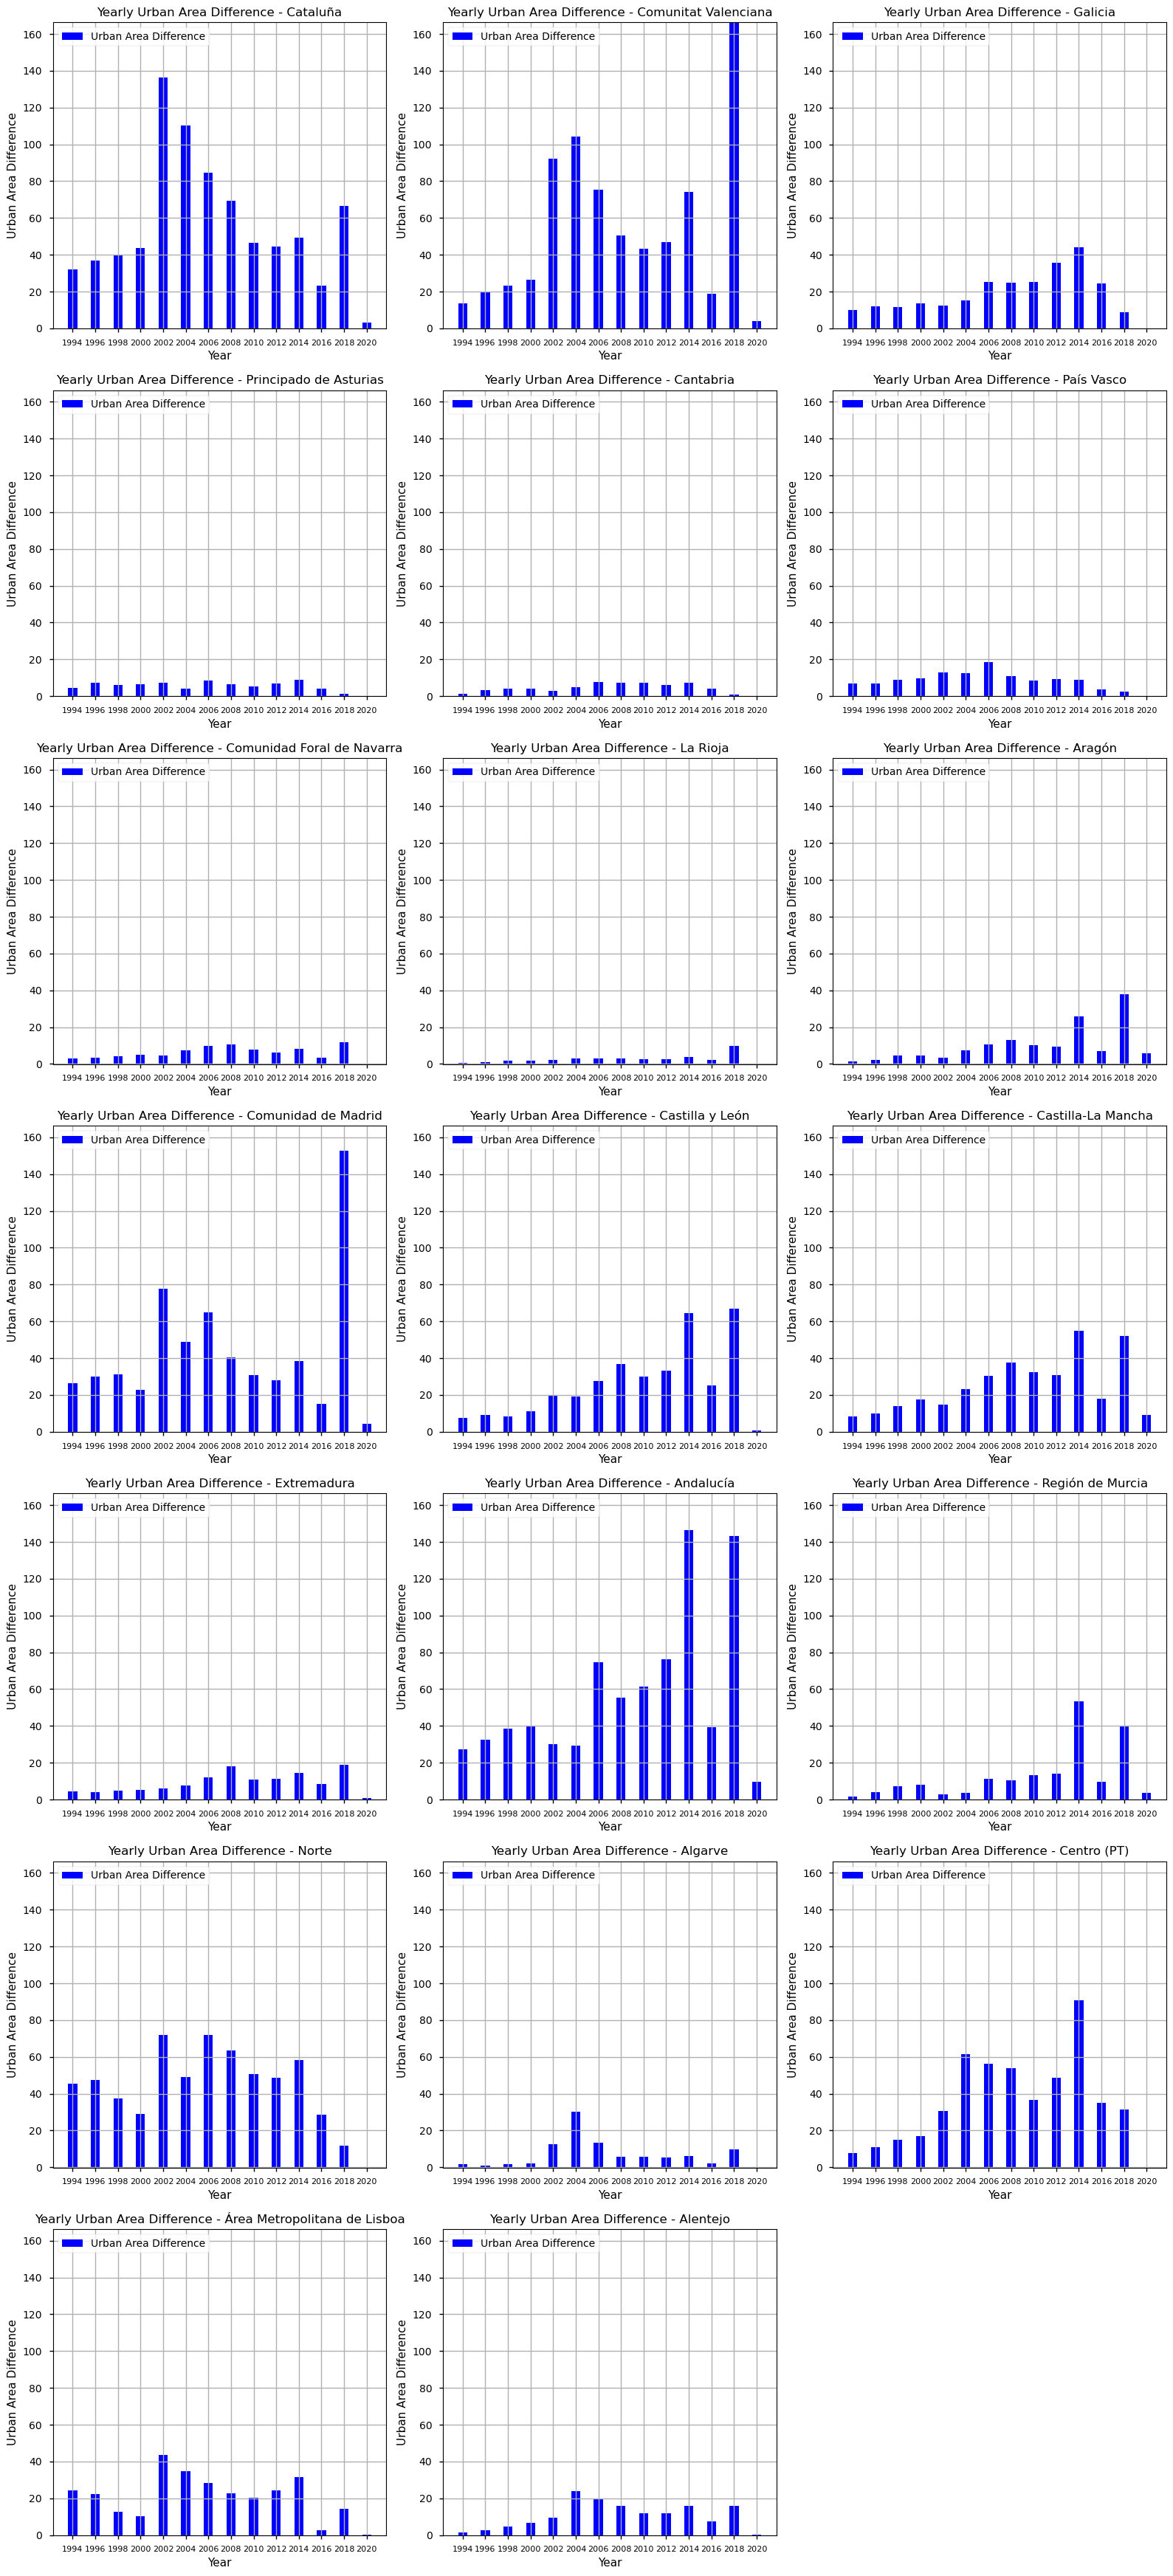

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing data processing code remains unchanged...

# New code to calculate yearly urban area differences
yearly_area_diff = {}

for region, urban_area in growth.items():
    years = list(urban_area.keys())
    values = list(urban_area.values())
    yearly_area_diff[region] = [values[j] - values[j-1] for j in range(1, len(values))]

# All regions
all_regions = list(yearly_area_diff.keys())

# Number of regions
num_regions = len(all_regions)
cols = 3
rows = int(np.ceil(num_regions / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))

# Flatten the axes for easier iteration
axes = axes.ravel()

# Calculate the common y-axis limits
y_min = min([min(v) for v in yearly_area_diff.values()]) - 0.1
y_max = max([max(v) for v in yearly_area_diff.values()]) + 0.1

# Iterate through all regions and create plots on the same image
for idx, region in enumerate(all_regions):
    years = list(growth[region].keys())[1:]  # Exclude the first year
    values = yearly_area_diff[region]
    
    axes[idx].bar(years, values, label='Area Diff', color='b')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Urban Area Difference')
    axes[idx].set_title(f'Yearly Urban Area Difference - {region}')
    axes[idx].grid(True)
    axes[idx].set_ylim(y_min, y_max)
    axes[idx].set_xticks(years)  # Set x-ticks to ensure all years are shown
    axes[idx].set_xticklabels(years, fontsize=8)  # Set fontsize for x-tick labels
    axes[idx].legend(['Urban Area Difference'], loc='upper left')

# Turn off empty subplots
for idx in range(num_regions, rows * cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


Map the slope in urbanization for the entired time-period

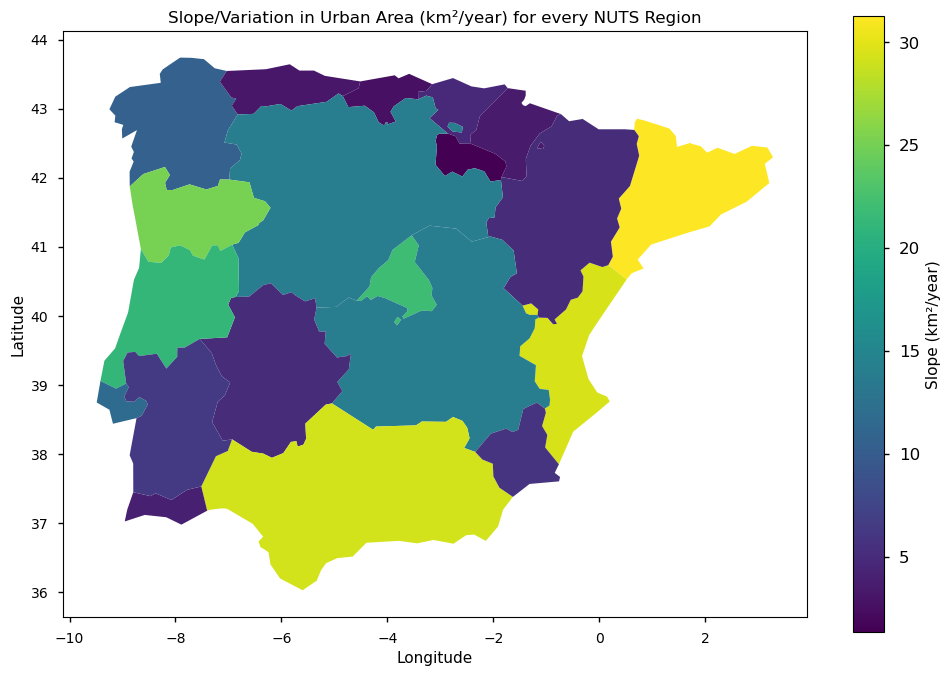

In [56]:
# Create a colormap
cmap = "viridis"
norm = colors.Normalize(vmin=merged_df["Slope"].min(), vmax=merged_df["Slope"].max())

# # Plot the GeoDataFrame with slope values as the colormap
fig, ax = plt.subplots(figsize=(12, 8))
merged_df.plot(column="Slope", cmap=cmap, ax=ax, norm=norm)

#Add a colorbar with a legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array to create a colorbar
cbar = plt.colorbar(sm, ax=ax, label="Slope")
cbar.set_label("Slope (km²/year)", rotation=90)
cbar.ax.tick_params(labelsize=12)

plt.title("Slope/Variation in Urban Area (km²/year) for every NUTS Region")
#plt.axis("off")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Maps the percentage difference in urban area

In [58]:
# Create a new dictionary to store the percentage differences
percentage_differences = {}

# Iterate through the regions
for region, data in growth.items():
    # Get the urban areas for the first and last years
    urban_area_first_year = data[min(data.keys())]
    urban_area_last_year = data[max(data.keys())]

    # Calculate the percentage difference
    percentage_difference = ((urban_area_last_year - urban_area_first_year) / urban_area_first_year) * 100

    # Store the result in the new dictionary
    
    percentage_differences[region] = percentage_difference


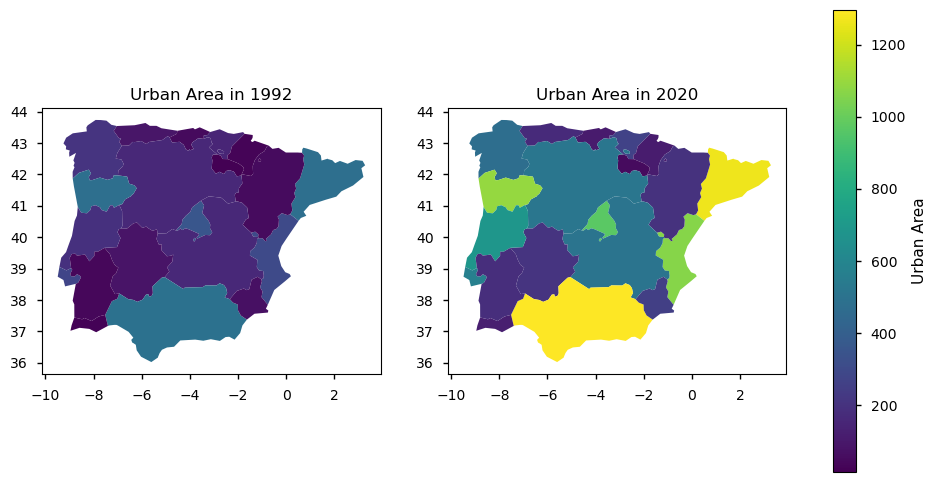

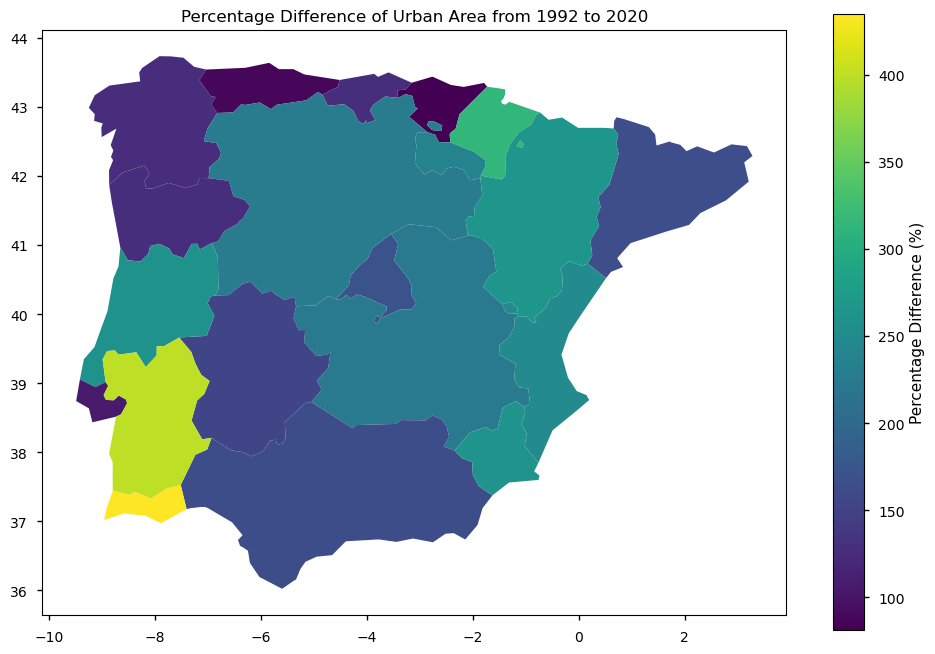

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
# Convert the "growth" dictionary into a DataFrame suitable for plotting
growth_df = pd.DataFrame([(region, year, value) for region, years in growth.items() for year, value in years.items()],
                         columns=["NUTS_NAME", "Year", "Urban_Area"])

# Pivot the DataFrame to have years as columns
growth_pivot = growth_df.pivot(index="NUTS_NAME", columns="Year", values="Urban_Area").reset_index()

# Merge the pivoted DataFrame with "pt_aoi" based on "NUTS_NAME"
pt_aoi_growth = pt_aoi.merge(growth_pivot, on="NUTS_NAME")

# Create a common color normalization for both maps
norm = plt.Normalize(vmin=pt_aoi_growth[1992].min(), vmax=pt_aoi_growth[2020].max())

# Plot the maps for urban areas in 1992 and 2020
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pt_aoi_growth.plot(column=1992, cmap="viridis", ax=axes[0], norm=norm)
pt_aoi_growth.plot(column=2020, cmap="viridis", ax=axes[1], norm=norm)
axes[0].set_title("Urban Area in 1992")
axes[1].set_title("Urban Area in 2020")

# Manually create a single ScalarMappable object for colorbar
sm_common = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm_common._A = []  # Dummy array to create the colorbar
cbar_common = plt.colorbar(sm_common, ax=axes, label="Urban Area (km²)")

# Set colorbar labels
cbar_common.set_label("Urban Area", rotation=90)

# Create a GeoDataFrame for percentage difference
percentage_difference_df = pd.DataFrame(list(percentage_differences.items()), columns=["NUTS_NAME", "percentage_difference"])

# Merge the GeoDataFrame with "pt_aoi" based on "NUTS_NAME"
pt_aoi_percentage_difference = pt_aoi.merge(percentage_difference_df, on="NUTS_NAME")

# Plot the map for percentage difference
fig, ax = plt.subplots(figsize=(12, 8))
pt_aoi_percentage_difference.plot(column="percentage_difference", cmap="viridis", ax=ax)
ax.set_title("Percentage Difference of Urban Area from 1992 to 2020")

# Manually create ScalarMappable object for colorbar
sm_percentage_difference = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=pt_aoi_percentage_difference["percentage_difference"].min(), vmax=pt_aoi_percentage_difference["percentage_difference"].max()))
sm_percentage_difference._A = []  # Dummy array to create the colorbar
cbar_percentage_difference = plt.colorbar(sm_percentage_difference, ax=ax, label="Percentage Difference (%)")

# Set colorbar label
cbar_percentage_difference.set_label("Percentage Difference (%)", rotation=90)

# Show the plots
plt.show()


## 7. References:

1. Eurostat Nomenclature of territorial units for statistics regions and definition (NUTS) - https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts
    
2. Land Cover dataset Product User Guide (PUG) - https://datastore.copernicus-climate.eu/documents/satellite-land-cover/D5.3.1_PUGS_ICDR_LC_v2.1.x_PRODUCTS_v1.1.pdf

3. Eurostat, Cities (Urban Audit) - https://ec.europa.eu/eurostat/web/cities/data/database

4. Urbanisation: Trends and drivers - https://www.fao.org/3/cc3017en/online/state-food-security-and-nutrition-2023/drivers-patterns-dynamics-urbanization.html
                                    - https://urban.jrc.ec.europa.eu/thefutureofcities/urbanisation#the-chapter
                                    - https://www.jstor.org/stable/43646772
                                    - https://muse.jhu.edu/article/725977
                                    - https://www.mdpi.com/2073-445X/7/3/99